In [420]:
from matplotlib._api import rename_parameter
from sqlalchemy.types import Variant
import torch
import torch.nn as  nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader , Dataset
import torchvision as transforms
import os , sys
import dotenv
import pytorch_lightning as pl
from sklearn import preprocessing
from pytorch_lightning.loggers import WandbLogger
from argparse import Namespace
import sklearn
from  pathlib import Path
from collections import OrderedDict
#import wandb
from sklearn.preprocessing import LabelEncoder

In [421]:

for dirname, _ , filenames in os.walk('data/'):
    for file in filenames:
        print(os.path.join(dirname,file))

data_path = 'data/realKnownCause/machine_temperature_system_failure.csv'
datasets_root = Path('data')

data/train.csv
data/README.md
data/test.csv
data/realAdExchange/exchange-4_cpc_results.csv
data/realAdExchange/exchange-3_cpm_results.csv
data/realAdExchange/exchange-3_cpc_results.csv
data/realAdExchange/exchange-2_cpc_results.csv
data/realAdExchange/exchange-4_cpm_results.csv
data/realAdExchange/exchange-2_cpm_results.csv
data/artificialNoAnomaly/art_flatline.csv
data/artificialNoAnomaly/art_daily_small_noise.csv
data/artificialNoAnomaly/art_daily_perfect_square_wave.csv
data/artificialNoAnomaly/art_daily_no_noise.csv
data/artificialNoAnomaly/art_noisy.csv
data/artificialWithAnomaly/art_daily_jumpsdown.csv
data/artificialWithAnomaly/art_load_balancer_spikes.csv
data/artificialWithAnomaly/art_daily_jumpsup.csv
data/artificialWithAnomaly/art_daily_nojump.csv
data/artificialWithAnomaly/art_daily_flatmiddle.csv
data/artificialWithAnomaly/art_increase_spike_density.csv
data/realTraffic/speed_6005.csv
data/realTraffic/occupancy_6005.csv
data/realTraffic/occupancy_t4013.csv
data/realTraffic

In [422]:



'''

We do not have much information about what kind of machine or industry we are dealing with, which is a bit of an issue when trying to use this data, especially when it comes to feature engineering. We will therefore have to make assumptions.

The timestamps cover the Christmas and New Year holidays. Since we are dealing with an industrial machine, it stands to reason that its workload might be affected by holidays, and maybe even by the proximity (in time) of a holiday. In the absence of additional information, we are going to assume that the applicable holidays are those typical in Europe and the Americas, i.e. Christmas and New Year's Day. By the same reasoning, we might need to know the day of the week (possibly lower workload on weekends?) or the hour of the day. Again, we will assume that weekends are Satuday and Sunday.
'''

df = pd.read_csv(data_path)
data = df.copy()
raw_value = data['value']
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['day'] = data['timestamp'].dt.day
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute/60
data['month'] = data['timestamp'].dt.month
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0

data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
print(holidays)
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

print(data.head())

[datetime.date(2013, 12, 25) datetime.date(2014, 1, 1)]
            timestamp      value  day   hour_min  month  day_of_week  holiday  \
0 2013-12-02 21:15:00  73.967322    2  21.250000     12            0        0   
1 2013-12-02 21:20:00  74.935882    2  21.333333     12            0        0   
2 2013-12-02 21:25:00  76.124162    2  21.416667     12            0        0   
3 2013-12-02 21:30:00  78.140707    2  21.500000     12            0        0   
4 2013-12-02 21:35:00  79.329836    2  21.583333     12            0        0   

               hol_0              hol_1  
0  -23 days, 0:00:00  -30 days, 0:00:00  
1  -23 days, 0:00:00  -30 days, 0:00:00  
2  -23 days, 0:00:00  -30 days, 0:00:00  
3  -23 days, 0:00:00  -30 days, 0:00:00  
4  -23 days, 0:00:00  -30 days, 0:00:00  


In [423]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']
data['gap_holiday'] = data['gap_holiday'].astype('timedelta64[ns]')


data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)

data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)

cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

label_encoders = [LabelEncoder() for _ in cat_vars]
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])


data['gap_holiday'] = data['gap_holiday'].dt.total_seconds().astype(float)
print(data.head())

       value  day   hour_min  month  day_of_week  holiday  gap_holiday  \
0  73.967322    1  21.250000      2            0        0   -1987200.0   
1  74.935882    1  21.333333      2            0        0   -1987200.0   
2  76.124162    1  21.416667      2            0        0   -1987200.0   
3  78.140707    1  21.500000      2            0        0   -1987200.0   
4  79.329836    1  21.583333      2            0        0   -1987200.0   

          t  
0  13860189  
1  13860192  
2  13860195  
3  13860198  
4  13860201  


In [424]:
test_ratio = 0.3
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [425]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])
tst_data_scaled = pd.DataFrame(tst_data_scaled)
print(tr_data_scaled.head())

      value  day  hour_min  month  day_of_week  holiday  gap_holiday         t
0 -1.224398    1  1.336685      2            0        0    -1.866199 -1.732808
1 -1.134136    1  1.348691      2            0        0    -1.866199 -1.732590
2 -1.023399    1  1.360698      2            0        0    -1.866199 -1.732372
3 -0.835474    1  1.372704      2            0        0    -1.866199 -1.732153
4 -0.724658    1  1.384711      2            0        0    -1.866199 -1.731935


In [426]:
tr_data_scaled.to_csv(datasets_root/'train.csv', index=False)
tst_data_scaled.to_csv(datasets_root/'test.csv', index=False)

In [470]:
class TSDataset(Dataset):
    def __init__(self, split, cont_vars=None, cat_vars=None, lbl_as_feat=True):
        """
        split: 'train' if we want to get data from the training examples, 'test' for
        test examples, or 'both' to merge the training and test sets and return samples
        from either.
        cont_vars: List of continuous variables to return as features. If None, returns
        all continuous variables available.
        cat_vars: Same as above, but for categorical variables.
        lbl_as_feat: Set to True when training a VAE -- the labels (temperature values)
        will be included as another dimension of the data. Set to False when training
        a model to predict temperatures.
        """
        super().__init__()
        assert split in ['train', 'test', 'both']
        self.lbl_as_feat = lbl_as_feat
        if split == 'train':
            self.df = pd.read_csv(datasets_root/'train.csv')
        elif split == 'test':
            self.df = pd.read_csv(datasets_root/'test.csv')
        else:
            df1 = pd.read_csv(datasets_root/'train.csv')
            df2 = pd.read_csv(datasets_root/'test.csv')
            self.df = pd.concat((df1, df2), ignore_index=True)
        
        # Select continuous variables to use
        if cont_vars:
            self.cont_vars = cont_vars
            # If we want to use 'value' as a feature, ensure it is returned
            if self.lbl_as_feat:
                try:
                    assert 'value' in self.cont_vars
                except AssertionError:
                    self.cont_vars.insert(0, 'value')
            # If not, ensure it not returned as a feature
            else:
                try:
                    assert 'value' not in self.cont_vars
                except AssertionError:
                    self.cont_vars.remove('value')
                    
        else:  # if no list provided, use all available
            self.cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
        
        # Select categorical variables to use
        if cat_vars:
            self.cat_vars = cat_vars
        else:  # if no list provided, use all available
            self.cat_vars = ['day_of_week', 'holiday']
        
        # Finally, make two Numpy arrays for continuous and categorical
        # variables, respectively:
        if self.lbl_as_feat:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)

            print("cont features shape : ",self.cont.shape)
        else:
            self.cont = self.df[self.cont_vars].copy().to_numpy(dtype=np.float32)
            print("cont features shape : ",self.cont.shape)
            self.lbl = self.df['value'].copy().to_numpy(dtype=np.float32)
        self.cat = self.df[self.cat_vars].copy().to_numpy(dtype=np.int64)
        print("cat features shape : ",self.cat.shape)
            
    def __getitem__(self, idx):
        if self.lbl_as_feat:  # for VAE training
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx])
        else:  # for supervised prediction
            return torch.tensor(self.cont[idx]), torch.tensor(self.cat[idx]), torch.tensor(self.lbl[idx])
    
    def __len__(self):
        return self.df.shape[0]

In [626]:
class Encoder(nn.Module):

    def __init__(self, **hparams):
        super().__init__()

        self.hparams = Namespace(**hparams)
        self.embeds = nn.ModuleList([
            nn.Embedding(n_cats, emb_size) for (n_cats, emb_size) in self.hparams.embedding_sizes
        ])
        in_dim = sum(emb.embedding_dim for emb in self.embeds) + len(self.hparams.cont_vars)

        # for emb in self.embeds:
        #     print(emb.embedding_dim)

        # print(in_dim)
        layer_dims = [in_dim] + [int(s) for s in self.hparams.layer_sizes.split(',')]
        # print(layer_dims[3])
        # for i in range(len(layer_dims)-2):
        self.fc1 = nn.Linear(layer_dims[0] , layer_dims[1]) # 36 , 64
        self.fc2 = nn.Linear(layer_dims[1] , layer_dims[2])  # 64 , 128
        self.fc3 = nn.Linear(layer_dims[2] , layer_dims[3])  # 128 ,256
        # self.fc4 = nn.Linear(layer_dims[3] , self.hparams.z_dim) # 256
        # self.fc2 = nn.Linear(self.hparams.h_dim1 , self.hparams.h_dim2)
        # self.fc3  = nn.Linear(self.hparams.h_dim2, self.hparams.h_dim3)

        self.mu = nn.Linear(layer_dims[3], self.hparams.z_dim)
        self.log_var = nn.Linear(layer_dims[3], self.hparams.z_dim)
        self.relu = nn.ReLU()
    def forward(self,x_cont,x_cat):
        x1 = [emb(x_cat[:,i]) for i,emb in enumerate(self.embeds)]
        # x  = torch.tensor(x)
        
        # print(len(x1))
        x = torch.cat(x1,dim=1)
        input = torch.cat((x,x_cont),dim=1)
        x = self.relu(self.fc1(input))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        # x = self.relu(self.fc4(x))
        mu = self.mu(x)
        log_var = self.log_var(x)
       


        return mu, log_var ,input

In [627]:
class Decoder(nn.Module):

    def __init__(self, **hparams):
        super().__init__()

        self.hparams = Namespace(**hparams)
        # self.embed = torch.nn.Embedding(self.hparams.embed_size , 
        self.z_dim = self.hparams.z_dim
        layer_size1 = [self.z_dim] + [int(s) for s in self.hparams.layer_sizes.split(',')[-2:]]
        out_dim = sum(emb_size for _, emb_size in self.hparams.embedding_sizes) + len(self.hparams.cont_vars)
        # print(out_dim)
        # print(layer_size1)
        self.fc1 = nn.Linear(layer_size1[0],layer_size1[1])
        self.fc2 = nn.Linear(layer_size1[1], layer_size1[2])
        self.fc3 = nn.Linear(layer_size1[2], out_dim)
        # self.fc3  = nn.Linear(self.hparams.h_dim2, self.hparams.h_dim1)

        # self.ouput = nn.Linear(self.hparams.h_dim3, self.hparams.input_dim)
        self.relu = nn.ReLU()
    def forward(self,z):
        z = self.relu(self.fc1(z))
        z = self.relu(self.fc2(z))
        out = self.relu(self.fc3(z))
        
        out = torch.sigmoid(out)
        return out


class VariationalEncoders(nn.Module):
    def __init__(self,**hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)
        self.encoder = Encoder(**hparams)
        self.decoder = Decoder(**hparams)
    def reparametrize(self,mu,log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) * self.hparams.stdev1
        z = eps * std + mu
        return z
    def forward(self,x_cont,x_cat):
        
        mu , log_var , data_h = self.encoder(x_cont,x_cat)
        z = self.reparametrize(mu,log_var)
        out = self.decoder(z)
        # print(mu.shape,z.shape,log_var.shape,out.shape)
        return out , mu , log_var, data_h
def vae_loss(mu,log_var,out,x):
    
    recon_loss = torch.nn.functional.smooth_l1_loss(out,x,reduction='mean')
   
    kld= -0.5 * torch.mean(1 + log_var - mu ** 2 - log_var.exp())

    loss = recon_loss + 0.05 * kld
    return recon_loss, kld,loss


In [628]:
cont_features = ['value', 'hour_min', 'gap_holiday', 't'] 
cat_features = ['day_of_week', 'holiday']  # Remember that we removed `day` and `month`
embed_cats = [len(tr_data_scaled[c].unique()) for c in cat_features]
print(embed_cats)
hparams = OrderedDict(
    cont_vars = cont_features,
    cat_vars = cat_features,
    embedding_sizes=[(embed_cats[i], 16) for i in range(len(embed_cats))],
    z_dim = 16,
    stdev1 = 0.1,
    kld_beta = 0.05,
    lr = 0.001,
    weight_decay = 1e-5,
    batch_size = 128,
    epochs = 60,
    # input_dim = 4,
    layer_sizes='64,128,256,128,64',
    h_dim1 = 10,
    h_dim2 = 20,
    h_dim3 = 8,
    
)






[7, 2]


In [629]:
ds = TSDataset(split='both', cont_vars=cont_features, cat_vars=cat_features, lbl_as_feat=True)
print(len(ds))
it = iter(ds)
for _ in range(10):
    print(next(it))

cont features shape :  (22695, 4)
cat features shape :  (22695, 2)
22695
(tensor([-1.2244,  1.3367, -1.8662, -1.7328]), tensor([0, 0]))
(tensor([-1.1341,  1.3487, -1.8662, -1.7326]), tensor([0, 0]))
(tensor([-1.0234,  1.3607, -1.8662, -1.7324]), tensor([0, 0]))
(tensor([-0.8355,  1.3727, -1.8662, -1.7322]), tensor([0, 0]))
(tensor([-0.7247,  1.3847, -1.8662, -1.7319]), tensor([0, 0]))
(tensor([-0.7824,  1.3967, -1.8662, -1.7317]), tensor([0, 0]))
(tensor([-0.6371,  1.4087, -1.8662, -1.7315]), tensor([0, 0]))
(tensor([-0.6368,  1.4207, -1.8662, -1.7313]), tensor([0, 0]))
(tensor([-0.6293,  1.4327, -1.8662, -1.7311]), tensor([0, 0]))
(tensor([-0.7101,  1.4447, -1.8662, -1.7308]), tensor([0, 0]))


In [643]:
model = VariationalEncoders(**hparams)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)


cat_vars = cat_features
dataset = TSDataset('train', cont_vars=cont_vars, 
            cat_vars = cat_vars, lbl_as_feat=True
        )
    


dataset1 = TSDataset('test', cont_vars=cont_vars, 
            cat_vars = cat_vars, lbl_as_feat=True
        )
num_epochs = 20
device = 'cpu'
train_loader = DataLoader(dataset,shuffle=True,batch_size = 32)

test_loader = DataLoader(dataset1,shuffle=True,batch_size = 32)

cont features shape :  (15886, 4)
cat features shape :  (15886, 2)
cont features shape :  (6809, 4)
cat features shape :  (6809, 2)


In [644]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (x,y) in enumerate(train_loader):
        optimizer.zero_grad()
        x_recon, mu, log_var, data_h = model(x,y)
     
        recon_loss,kld,loss = vae_loss(mu, log_var,x_recon, data_h)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}')

# Anomaly detection (Calculate reconstruction error)

Epoch 1/20, Loss: 0.4775
Epoch 2/20, Loss: 0.3092
Epoch 3/20, Loss: 0.1975
Epoch 4/20, Loss: 0.1234
Epoch 5/20, Loss: 0.0819
Epoch 6/20, Loss: 0.0645
Epoch 7/20, Loss: 0.0583
Epoch 8/20, Loss: 0.0565
Epoch 9/20, Loss: 0.0561
Epoch 10/20, Loss: 0.0560
Epoch 11/20, Loss: 0.0560
Epoch 12/20, Loss: 0.0560
Epoch 13/20, Loss: 0.0560
Epoch 14/20, Loss: 0.0560
Epoch 15/20, Loss: 0.0560
Epoch 16/20, Loss: 0.0560
Epoch 17/20, Loss: 0.0560
Epoch 18/20, Loss: 0.0561
Epoch 19/20, Loss: 0.0560
Epoch 20/20, Loss: 0.0560


In [645]:
# for x,y in train_loader:
#     for i in x:
#         print(i)
#         break
#     break

In [646]:
recon_loss1 = 0
model.eval()
reconstruction_errors = []
with torch.no_grad():
    for x1,y1  in test_loader:
        for x,y in zip(x1,y1):

            x = x.unsqueeze(0)
            y = y.unsqueeze(0)
            x_recon, mu, log_var,data_h = model(x,y)

            recon_loss,kld,loss = vae_loss(mu, log_var,x_recon, data_h)
            dataset1.df['loss'] = np.asarray(loss)
            recon_loss1 += loss 
      

    print(f'Loss: {recon_loss1/len(test_loader):.4f}')


mean, sigma = dataset1.df['loss'].mean(), dataset1.df['loss'].std()
print(f"mean :  {mean}  , std : {sigma}")

Loss: 4.1336
mean :  0.1473875194787979  , std : 0.0


In [647]:
dataset1.df.head()

,value,day,hour_min,month,day_of_week,holiday,gap_holiday,t,loss
0,0.128276,26,-1.712961,0,0,0,1.90255,1.732299,0.147388
1,-0.038872,26,-1.700954,0,0,0,1.90255,1.732517,0.147388
2,0.088313,26,-1.688948,0,0,0,1.90255,1.732736,0.147388
3,0.124557,26,-1.676941,0,0,0,1.90255,1.732954,0.147388
4,0.014094,26,-1.664935,0,0,0,1.90255,1.733172,0.147388


In [648]:
quant = 0.85
thresh = dataset1.df['loss'].quantile(quant)
print(f"quantile at 99 is {thresh}")

quantile at 99 is 0.1473875343799591


In [649]:
dataset1.df['anomaly'] = dataset1.df['loss'] > 0.23
data_with_losses =dataset1.df 

In [650]:
data_with_losses.head()

,value,day,hour_min,month,day_of_week,holiday,gap_holiday,t,loss,anomaly
0,0.128276,26,-1.712961,0,0,0,1.90255,1.732299,0.147388,False
1,-0.038872,26,-1.700954,0,0,0,1.90255,1.732517,0.147388,False
2,0.088313,26,-1.688948,0,0,0,1.90255,1.732736,0.147388,False
3,0.124557,26,-1.676941,0,0,0,1.90255,1.732954,0.147388,False
4,0.014094,26,-1.664935,0,0,0,1.90255,1.733172,0.147388,False


In [651]:
data_with_losses['anomaly'].unique()

array([False])

In [641]:
# from sklearn.manifold import TSNE
# import seaborn as sns


# def tsne_plot(targets, outputs):
#     print('generating t-SNE plot...')
#     # tsne_output = bh_sne(outputs)
#     tsne = TSNE(random_state=0)
#     tsne_output = tsne.fit_transform(outputs)

#     df = pd.DataFrame(tsne_output, columns=['x', 'y'])
#     df['targets'] = targets

#     plt.rcParams['figure.figsize'] = 10, 10
#     sns.scatterplot(
#         x='x', y='y',
#         hue='targets',
#         palette=sns.color_palette("hls", 10),
#         data=df,
#         marker='o',
#         legend="full",
#         alpha=0.5
#     )

#     plt.xticks([])
#     plt.yticks([])
#     plt.xlabel('')
#     plt.ylabel('')

#     # plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
#     print('done!')

# tsne_plot(targets=)

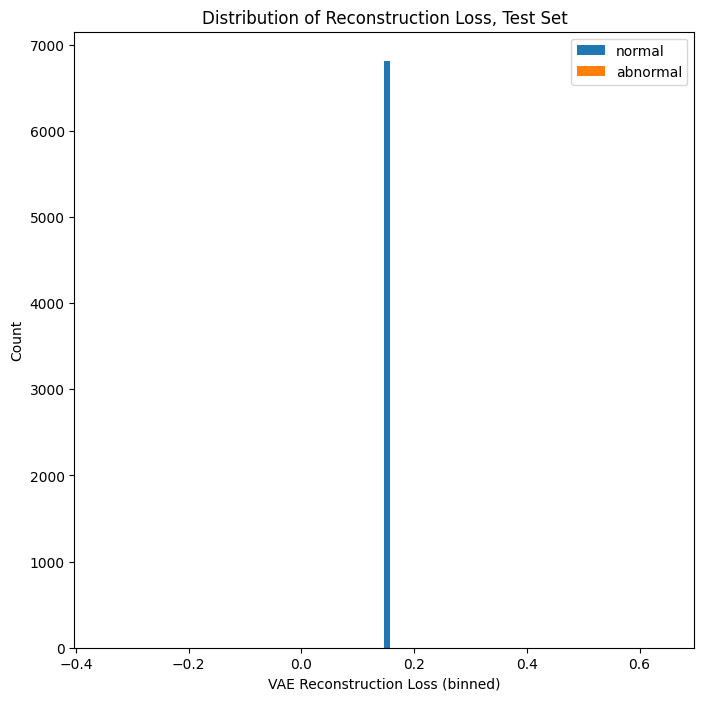

In [652]:


plt.figure(figsize=(8, 8))
anomalies_loss = data_with_losses.loc[data_with_losses['anomaly'], 'loss']

normals_loss   = data_with_losses.loc[~data_with_losses['anomaly'], 'loss']
plt.hist([normals_loss, anomalies_loss], bins=100, stacked=True, label=['normal', 'abnormal'])
plt.title("Distribution of Reconstruction Loss, Test Set")
plt.xlabel("VAE Reconstruction Loss (binned)")
plt.ylabel("Count")
plt.legend();
plt.show()